In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import abspath, dirname, join
import sys
from glob import glob
import random
import hydra
from hydra.experimental import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig
import cv2
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from tqdm import tqdm
import torch

root = abspath(join(dirname("__file__"), '../../'))
sys.path.append(root)

import matplotlib.pyplot as plt

# Initializing Hydra
There are several ways to initialize. See the [API docs](https://hydra.cc/docs/next/experimental/compose_api/#api-documentation) for full details.
All methods support both a function call style that changes the global state, and a context style that cleans up when theg scope exits.

## Global initialization
Calling each of the initilizaiton methods outside of a context changes the global state.

In [3]:
config_path = '../../configs'
config_name='test'

In [4]:
model_name = 'effdet_person_cosine_annealing'
model_folder = 'person' # '20200914_20_41_11'

In [5]:
# clear hyudra instance for running twice
hydra.core.global_hydra.GlobalHydra.instance().clear()

In [6]:
initialize(config_path=config_path)
model_id = '${MODEL_ID}'
cfg = compose(overrides=[f'+experiment={model_name}', f'MODEL_PATH=models/{model_id}/{model_folder}/', 'DATA.DATA_ID=demo_detection','DATA.TRAIN_IMAGE_DIR=data/${DATA.DATA_ID}/raw/train', 'TEST.TEST_IMAGE_DIR=data/${DATA.DATA_ID}/raw/test',
                         'DATA.CSV_PATH=data/${DATA.DATA_ID}/split/train_folds_demo.csv', 'DATA.EXTRACT_ONE_CLASS=true', 'DATA.FOLD_TARGET_COL=count'], config_name=config_name)
print(cfg)

{'FRAMEWORK': 'pytorch', 'TASK': 'detection', 'MODEL_PATH': 'models/${MODEL_ID}/person/', 'TEST_ID': 'test', 'DATA': {'DATA_ID': 'demo_detection', 'TRAIN_IMAGE_DIR': 'data/${DATA.DATA_ID}/raw/train', 'EXTRACT_ONE_CLASS': True, 'PROCESSED_CSV_NAME': '_features.csv', 'CSV_PATH': 'data/${DATA.DATA_ID}/split/train_folds_demo.csv', 'RANDOM_KFOLD': False, 'TEST_SIZE': 0.2, 'N_FOLD': 1, 'FORMAT': 'pascal_voc', 'IMAGE_ID_COL_NAME': 'ImageID', 'FOLD_TARGET_COL': 'count', 'REMOVE_LARGE_BBOXES': False, 'LARGE_BBOX_AREA_THRESHOLD': 200000}, 'DATASET': {'CLASS_NAME': 'src.data.generator.detection.dataset.DatasetRetriever', 'CUTMIX': False}, 'TEST': {'BATCH_SIZE': 2, 'TEST_IMAGE_DIR': 'data/${DATA.DATA_ID}/raw/test', 'TEST_CSV_PATH': 'data/${DATA.DATA_ID}/split/test_person_v3.csv', 'VISUALIZE_RESULTS': True, 'VAL_PRED_IMG_DIR': 'pred_images/validation/', 'TEST_PRED_IMG_DIR': 'pred_images/test/', 'SAVE_ALL_IMAGES': False, 'DETECTION_THRESHOLD': 0.2, 'FIND_BEST_THR': True, 'ENSEMBLE_METHOD': 'WBF', 'B

# Preprocess for Open Images Dataset

## Move to Root Directory(./BaseModel)

In [7]:
%cd ../../

/data1/r_suzuki/pipeline/BaseModel


In [8]:
!tree  data/demo_detection/

data/demo_detection/
├── interim
│   └── sample_images
│       ├── test
│       │   ├── gt_149a459813317be1.jpg
│       │   ├── gt_478d929a2ec56e03.jpg
│       │   ├── gt_4c654d7f4a8c2ccf.jpg
│       │   ├── gt_50ef808aa89eec7a.jpg
│       │   ├── gt_53235fa4c05102cb.jpg
│       │   ├── gt_7c33c6e015d44d6b.jpg
│       │   ├── gt_844d25e32ef08450.jpg
│       │   ├── gt_b75143a7ee175404.jpg
│       │   ├── gt_de2562ad4e4a657c.jpg
│       │   └── gt_e0b3db284bfa2bdc.jpg
│       └── train
│           ├── gt_0685936b4a617baf.jpg
│           ├── gt_09da4fa5d6dffff1.jpg
│           ├── gt_6170e872f1ffe5fc.jpg
│           ├── gt_8a66df5d9e493af8.jpg
│           ├── gt_952e7b4c05aff6a5.jpg
│           ├── gt_9b7f33948dd3d2b9.jpg
│           ├── gt_ba79fb53f1a0a730.jpg
│           ├── gt_c0121f7e94703f2c.jpg
│           ├── gt_cc2da67c017f908b.jpg
│           └── gt_fdc3bed26327961b.jpg
├── raw
│   ├── test
│   │   ├── 149a459813317be1.jpg
│   │   ├── 478d929a2ec56e03.jpg
│   │   ├── 4c654d7f4a8

## Check Raw Annotation Data

In [9]:
test_raw = pd.read_csv('./data/demo_detection/raw/test.csv')

In [10]:
test_raw.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,b75143a7ee175404,freeform,/m/01g317,1.0,0.206877,0.547636,0.544222,0.745045,0.0,0.0,0.0,0.0,0.0
1,b75143a7ee175404,freeform,/m/01g317,1.0,0.606185,0.865852,0.625181,0.776703,1.0,0.0,0.0,0.0,0.0
2,50ef808aa89eec7a,freeform,/m/01g317,1.0,0.374614,0.439428,0.219408,0.265544,1.0,0.0,0.0,0.0,0.0
3,50ef808aa89eec7a,freeform,/m/01g317,1.0,0.954990,0.984451,0.092780,0.128118,0.0,0.0,0.0,0.0,0.0
4,4c654d7f4a8c2ccf,freeform,/m/01g317,1.0,0.098487,0.373922,0.090896,0.845095,0.0,0.0,0.0,0.0,0.0


## Build Features

In [11]:
from src.preprocess.detection.build_features import build_features, make_target_df, extract_one_label, remove_flagged_rows, plot_bboxes, make_class_col
from src.preprocess.detection.xml_to_csv import check_glob_list_size

def get_annotations(cfg, mode, out_csv_name):
    """ Get annotations csv from interim or raw folders.
        csv name must be start with {mode}.

    Args:
        cfg (DictConfig): configs for preprocessing
        mode (str): should be 'all' or 'train' or 'valid' or 'test'
        out_csv_name (str): output csv file name including extension.

    Raises:
        ValueError: can not find csv file in both interim and raw directories.

    Returns:
        pd.DataFrame: dataframe from raw or interim path.
    """
    interim_csv_path = f'./data/{cfg.DATA.DATA_ID}/interim/{mode}*.csv'
    interim_list_len, interim_csv_path_list  = check_glob_list_size(interim_csv_path)
    if interim_list_len == 0:
        raw_csv_path = f'./data/{cfg.DATA.DATA_ID}/raw/{mode}*.csv'
        list_len, raw_csv_path_list = check_glob_list_size(raw_csv_path)
        if list_len == 0:
            if mode == 'valid' or mode == 'all':
                print(f'"{mode}" csv not found.')
                annotation_df = None
                return annotation_df
            else:
                raise ValueError(f'Can not find a "{mode}" csv in both "raw" and "interim" directories.')
        else:
            print('-'*30, f'Found a {mode} csv file in "raw" directory', '-'*30)
            annotation_path = raw_csv_path_list[0]
    else:
        print('-'*30, f'Found a {mode} csv file in "iterim" directory', '-'*30)
        annotation_path = interim_csv_path_list[0]
        csv_name = annotation_path.split('/')[-1]
        if csv_name == out_csv_name:
            print('-'*20, f'Found output csv file named "{csv_name}" in "iterim" directory', '-'*20)
            sys.exit(0)
    print(f'Loading Annotations from: {annotation_path}')
    annotation_df = pd.read_csv(annotation_path, dtype={cfg.DATA.IMAGE_ID_COL_NAME: str})
    print(f'{mode} csv length: ', len(annotation_df))
    return annotation_df


def get_images(cfg):
    """ Glob the directories and get the lists of train and test images

    Args:
        cfg (DictConfig): configs for preprocessing

    Raises:
        ValueError: can not find train images in "train_img_dir"

    Returns:
        str, list: train and test images directories and image list in the directories.
    """
    train_img_dir = cfg.DATA.TRAIN_IMAGE_DIR
    train_fns = glob(cfg.DATA.TRAIN_IMAGE_DIR + '/*')
    print(f'Found {len(train_fns)} train images')
    if len(train_fns) == 0:
        raise ValueError(f'Set train images in {train_img_dir}')
    
    test_fns = glob(cfg.TEST.TEST_IMAGE_DIR + '/*')
    print(f'Found {len(test_fns)} test images')

    if len(test_fns) > 0:
        test_img_dir = cfg.TEST.TEST_IMAGE_DIR
    else:
        test_img_dir = cfg.DATA.TRAIN_IMAGE_DIR
        print(f'Test images are set in {test_img_dir}')

    if test_img_dir == train_img_dir:
        print(f'Train and test images are in the same directory. \n {train_img_dir}')

    return train_img_dir, test_img_dir, train_fns, test_fns


def build_features_main(cfg):
    print('-'*30, 'Building Features', '-'*30)
    # output 
    output_dir = f'./data/{cfg.DATA.DATA_ID}/interim/'
    plot_image_dir = f'./data/{cfg.DATA.DATA_ID}/interim/sample_images/'
    save_sample_images = True

    # get images list
    train_img_dir, test_img_dir, train_fns ,test_fns = get_images(cfg)

    mode_list = ['all', 'train', 'valid', 'test']
    for mode in mode_list:
        print('-'*30, f'Processing mode: {mode}', '-'*30)

        out_csv_name = mode + cfg.DATA.PROCESSED_CSV_NAME
        annotations = get_annotations(cfg, mode=mode, out_csv_name=out_csv_name)

        if annotations is None:
           print('-'*30, f'No annotations for "{mode}"', '-'*30)
           continue

        if mode == 'test':
            img_list=test_fns
        else:
            img_list=train_fns

        # make dataframe matched images
        target_df = make_target_df(annotations, img_list=img_list, image_id_col_name = cfg.DATA.IMAGE_ID_COL_NAME, drop_na=True)
        print(f'Target {mode} csv length: ', len(target_df))
        
        # remove rows using flags
        remove_flagged_col_list = ['IsTruncated', 'IsGroupOf', 'IsDepiction']
        target_df = remove_flagged_rows(target_df, remove_flagged_col_list)

        # class column process 
        target_df = make_class_col(target_df)

        open_images_label_col_name='LabelName'
        if cfg.MODEL.NUM_CLASSES == 1:
            if open_images_label_col_name in target_df.columns and cfg.DATA.EXTRACT_ONE_CLASS:
                print('-'*30, f'Extracting 1 class from {target_df[open_images_label_col_name].nunique()} classes', '-'*30)
                target_label_id='/m/01g317' # person label
                target_df = extract_one_label(target_df, label_col_name=open_images_label_col_name, target_label_id=target_label_id, mode=mode)
            else:
                print('-'*30, 'Number of Class: 1', '-'*30)
        else:
            if open_images_label_col_name in target_df.columns:
                print('-'*30, f'Found {target_df[open_images_label_col_name].nunique()} Classes', '-'*30)

        # build features for detection task
        if mode == 'test':        
            if ('bbox' in target_df.columns) or ('xmin' in target_df.columns) or ('XMin' in target_df.columns):
                target_df = build_features(cfg=cfg, df=target_df, img_dir=test_img_dir, output_dir=output_dir, out_csv_name=cfg.DATA.PROCESSED_CSV_NAME, mode=mode)
        else:
            target_df = build_features(cfg=cfg, df=target_df, img_dir=train_img_dir, output_dir=output_dir, out_csv_name=cfg.DATA.PROCESSED_CSV_NAME, mode=mode)
       
       # save images to check ground truth
        if save_sample_images:
            print('-'*30, 'Plotting Sample Images with Boxes', '-'*30)
            if mode == 'test': 
                if ('bbox' in target_df.columns) or ('xmin' in target_df.columns) or ('XMin' in target_df.columns):
                    plot_bboxes(target_df, plot_image_dir + 'test', test_img_dir)
            else:
                plot_bboxes(target_df, plot_image_dir + 'train', train_img_dir)
        
        print('-'*30, f'Done Processing {mode} !', '-'*30)

        if mode == 'all':
            break

    print('-'*30, f'Buiding Feature Finished Successfully!', '-'*30)

In [12]:
build_features_main(cfg)

100%|██████████| 13/13 [00:00<00:00, 92.84it/s]

------------------------------ Building Features ------------------------------
Found 10 train images
Found 10 test images
------------------------------ Processing mode: all ------------------------------
Found 0 files in ./data/demo_detection/interim/all*.csv
Found 0 files in ./data/demo_detection/raw/all*.csv
"all" csv not found.
------------------------------ No annotations for "all" ------------------------------
------------------------------ Processing mode: train ------------------------------
Found 0 files in ./data/demo_detection/interim/train*.csv
Found ./data/demo_detection/raw/train.csv file  in ./data/demo_detection/raw/train*.csv
------------------------------ Found a train csv file in "raw" directory ------------------------------
Loading Annotations from: ./data/demo_detection/raw/train.csv
train csv length:  15
Renamed ImageID to image_id
Removed 5 images without target object.
Target train csv length:  15
Removing IsTruncated with flag : 1 boxes.
Removing IsGroupOf w

Renamed "Source" to "source" column.
train df saved to: ./data/demo_detection/interim/train_features.csv
------------------------------ Plotting Sample Images with Boxes ------------------------------
Sample Image Saved to: ./data/demo_detection/interim/sample_images/train/gt_9b7f33948dd3d2b9.jpg
Sample Image Saved to: ./data/demo_detection/interim/sample_images/train/gt_ba79fb53f1a0a730.jpg
Sample Image Saved to: ./data/demo_detection/interim/sample_images/train/gt_6170e872f1ffe5fc.jpg
Sample Image Saved to: ./data/demo_detection/interim/sample_images/train/gt_fdc3bed26327961b.jpg


 46%|████▌     | 11/24 [00:00<00:00, 107.08it/s]

Sample Image Saved to: ./data/demo_detection/interim/sample_images/train/gt_c0121f7e94703f2c.jpg
------------------------------ Done Processing train ! ------------------------------
------------------------------ Processing mode: valid ------------------------------
Found 0 files in ./data/demo_detection/interim/valid*.csv
Found ./data/demo_detection/raw/valid.csv file  in ./data/demo_detection/raw/valid*.csv
------------------------------ Found a valid csv file in "raw" directory ------------------------------
Loading Annotations from: ./data/demo_detection/raw/valid.csv
valid csv length:  27
Renamed ImageID to image_id
Removed 5 images without target object.
Target valid csv length:  27
Removing IsTruncated with flag : 1 boxes.
Removing IsGroupOf with flag : 1 boxes.
Removing IsDepiction with flag : 1 boxes.
------------------------------ Extracting 1 class from 1 classes ------------------------------
valid: Found Label ID: "/m/01g317" in LabelName column.
Found 24 rows in valid df

100%|██████████| 24/24 [00:00<00:00, 100.00it/s]


Found 0 error images
------------------------------ Making Box cols: valid ------------------------------
Renamed "Source" to "source" column.
valid df saved to: ./data/demo_detection/interim/valid_features.csv
------------------------------ Plotting Sample Images with Boxes ------------------------------
Sample Image Saved to: ./data/demo_detection/interim/sample_images/train/gt_cc2da67c017f908b.jpg
Sample Image Saved to: ./data/demo_detection/interim/sample_images/train/gt_0685936b4a617baf.jpg
Sample Image Saved to: ./data/demo_detection/interim/sample_images/train/gt_09da4fa5d6dffff1.jpg
Sample Image Saved to: ./data/demo_detection/interim/sample_images/train/gt_8a66df5d9e493af8.jpg


 33%|███▎      | 9/27 [00:00<00:00, 84.35it/s]

Sample Image Saved to: ./data/demo_detection/interim/sample_images/train/gt_952e7b4c05aff6a5.jpg
------------------------------ Done Processing valid ! ------------------------------
------------------------------ Processing mode: test ------------------------------
Found 0 files in ./data/demo_detection/interim/test*.csv
Found ./data/demo_detection/raw/test.csv file  in ./data/demo_detection/raw/test*.csv
------------------------------ Found a test csv file in "raw" directory ------------------------------
Loading Annotations from: ./data/demo_detection/raw/test.csv
test csv length:  27
Renamed ImageID to image_id
Removed 0 images without target object.
Target test csv length:  27
Removing IsTruncated with flag : 0 boxes.
Removing IsGroupOf with flag : 0 boxes.
Removing IsDepiction with flag : 0 boxes.
------------------------------ Extracting 1 class from 1 classes ------------------------------
test: Found Label ID: "/m/01g317" in LabelName column.
Found 27 rows in test df.
Found 10

100%|██████████| 27/27 [00:00<00:00, 100.39it/s]


Found 0 error images
------------------------------ Making Box cols: test ------------------------------
Renamed "Source" to "source" column.
test df saved to: ./data/demo_detection/interim/test_features.csv
------------------------------ Plotting Sample Images with Boxes ------------------------------
Sample Image Saved to: ./data/demo_detection/interim/sample_images/test/gt_149a459813317be1.jpg
Sample Image Saved to: ./data/demo_detection/interim/sample_images/test/gt_53235fa4c05102cb.jpg
Sample Image Saved to: ./data/demo_detection/interim/sample_images/test/gt_7c33c6e015d44d6b.jpg
Sample Image Saved to: ./data/demo_detection/interim/sample_images/test/gt_de2562ad4e4a657c.jpg
Sample Image Saved to: ./data/demo_detection/interim/sample_images/test/gt_b75143a7ee175404.jpg
Sample Image Saved to: ./data/demo_detection/interim/sample_images/test/gt_e0b3db284bfa2bdc.jpg
Sample Image Saved to: ./data/demo_detection/interim/sample_images/test/gt_478d929a2ec56e03.jpg
Sample Image Saved to: .

### Check Dataframes

In [13]:
train_features = pd.read_csv('./data/demo_detection/interim/train_features.csv')
valid_features = pd.read_csv('./data/demo_detection/interim/valid_features.csv')
test_features = pd.read_csv('./data/demo_detection/interim/test_features.csv')

In [14]:
test_features.head()

,image_id,image_path,source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,...,class_id,image_height,image_width,xmin,xmax,ymin,ymax,width,height,area
0,149a459813317be1,data/demo_detection/raw/test/149a459813317be1.jpg,freeform,/m/01g317,1.0,0.267317,0.281302,0.117320,0.162474,0.0,...,1,768.0,1024.0,273.732608,288.053248,90.101760,124.780032,14.320640,34.678272,496.615049
1,149a459813317be1,data/demo_detection/raw/test/149a459813317be1.jpg,freeform,/m/01g317,1.0,0.279094,0.290135,0.118302,0.157566,0.0,...,1,768.0,1024.0,285.792256,297.098240,90.855936,121.010688,11.305984,30.154752,340.929144
2,149a459813317be1,data/demo_detection/raw/test/149a459813317be1.jpg,freeform,/m/01g317,1.0,0.290135,0.301176,0.117320,0.158548,0.0,...,1,768.0,1024.0,297.098240,308.404224,90.101760,121.764864,11.305984,31.663104,357.982547
3,53235fa4c05102cb,data/demo_detection/raw/test/53235fa4c05102cb.jpg,freeform,/m/01g317,1.0,0.181743,0.871283,0.143234,0.888668,0.0,...,1,768.0,1024.0,186.104832,892.193792,110.003712,682.497024,706.088960,572.493312,404231.207277
4,7c33c6e015d44d6b,data/demo_detection/raw/test/7c33c6e015d44d6b.jpg,freeform,/m/01g317,1.0,0.151690,0.399178,0.021939,0.611598,0.0,...,1,927.0,1024.0,155.330560,408.758272,20.337453,566.951346,253.427712,546.613893,138527.108250


### Check Ground Truth

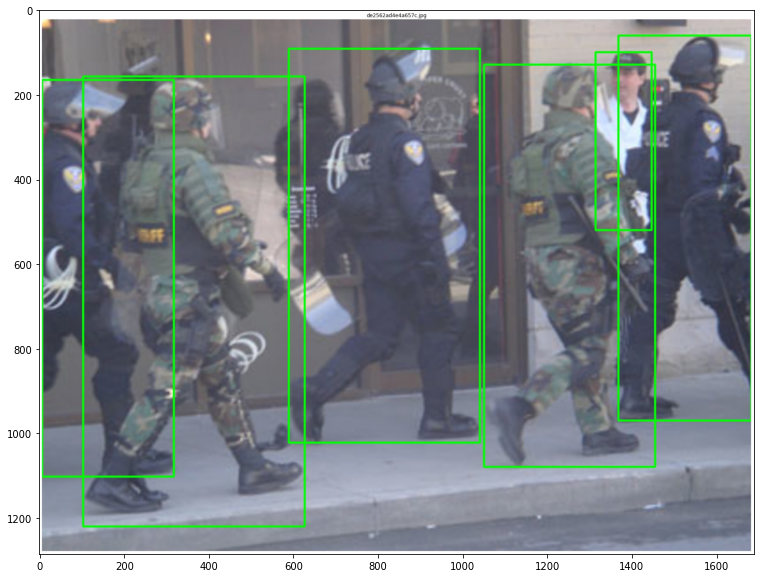

In [15]:
gt_img_dir = './data/demo_detection/interim/sample_images/test/'
gt_images = glob(gt_img_dir + '/*')
image_path = gt_images[0]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.show()

## Make Folds

In [16]:
from src.preprocess.detection.make_folds import make_leave_one_out, make_folds

def make_folds_main(cfg):
    print('-'*30, 'Making Train Val Folds', '-'*30)

    input_dir = f'./data/{cfg.DATA.DATA_ID}/interim/'

    train_df = get_annotations(cfg, mode='train', out_csv_name=cfg.DATA.CSV_PATH.split('/')[-1])
    valid_df = get_annotations(cfg, mode='valid', out_csv_name=cfg.DATA.CSV_PATH.split('/')[-1])

    if train_df is not None and valid_df is not None:
        train_folds = make_leave_one_out(train_df, valid_df)
    elif train_df is not None and valid_df is None:
        print('-'*30, f'Making {cfg.DATA.N_FOLD} Folds', '-'*30)
        train_folds = make_folds(train_df, image_id_col_name='image_id', bbox_col_name='bbox',
                                target_col_name=cfg.DATA.FOLD_TARGET_COL, n_fold=cfg.DATA.N_FOLD, seed=cfg.SYSTEM.SEED, random_kfold=cfg.DATA.RANDOM_KFOLD)
    else:
        raise ValueError(f'Can not make folds. check input files in {input_dir}')

    drop_col_list = ['id', 'ImageID', 'Source', 'Confidence', 'IsOccluded', 'IsGroupOf','IsTruncated', 'IsInside', 'IsDepiction', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']
    for col_name in drop_col_list:
        if col_name in train_folds.columns:
            train_folds = train_folds.drop([col_name], axis=1)
            print(f'Dropped "{col_name}" column.')

    print('-'*30, 'Output CSV Columns', '-'*30)
    print(train_folds.columns)
    
    folds_csv_path = cfg.DATA.CSV_PATH
    os.makedirs(os.path.dirname(folds_csv_path), exist_ok=True)
    train_folds.to_csv(folds_csv_path, index=False)
    print('Train Valid csv is saved to:', folds_csv_path)
    return train_folds

In [17]:
train_folds = make_folds_main(cfg)

------------------------------ Making Train Val Folds ------------------------------
Found ./data/demo_detection/interim/train_features.csv file  in ./data/demo_detection/interim/train*.csv
------------------------------ Found a train csv file in "iterim" directory ------------------------------
Loading Annotations from: ./data/demo_detection/interim/train_features.csv
train csv length:  13
Found ./data/demo_detection/interim/valid_features.csv file  in ./data/demo_detection/interim/valid*.csv
------------------------------ Found a valid csv file in "iterim" directory ------------------------------
Loading Annotations from: ./data/demo_detection/interim/valid_features.csv
valid csv length:  24
Dropped "Confidence" column.
Dropped "IsOccluded" column.
Dropped "IsGroupOf" column.
Dropped "IsTruncated" column.
Dropped "IsInside" column.
Dropped "IsDepiction" column.
Dropped "LabelName" column.
Dropped "XMin" column.
Dropped "XMax" column.
Dropped "YMin" column.
Dropped "YMax" column.
----

In [18]:
train_folds.head()

,image_id,image_path,source,class_id,image_height,image_width,xmin,xmax,ymin,ymax,width,height,area,fold
0,9b7f33948dd3d2b9,data/demo_detection/raw/train/9b7f33948dd3d2b9...,xclick,1,1024.0,684.0,13.437180,563.068116,380.800000,973.440000,549.630936,592.640000,325733.277911,1
1,9b7f33948dd3d2b9,data/demo_detection/raw/train/9b7f33948dd3d2b9...,xclick,1,1024.0,684.0,50.548284,148.445100,67.840000,240.640000,97.896816,172.800000,16916.569805,1
2,9b7f33948dd3d2b9,data/demo_detection/raw/train/9b7f33948dd3d2b9...,xclick,1,1024.0,684.0,167.640876,477.328032,349.440000,1023.360000,309.687156,673.920000,208704.368172,1
3,9b7f33948dd3d2b9,data/demo_detection/raw/train/9b7f33948dd3d2b9...,xclick,1,1024.0,684.0,398.626992,630.892188,39.680000,407.040000,232.265196,367.360000,85324.942403,1
4,ba79fb53f1a0a730,data/demo_detection/raw/train/ba79fb53f1a0a730...,xclick,1,768.0,1024.0,0.000000,1022.999552,249.000192,692.000256,1022.999552,443.000064,453188.867008,1


In [19]:
!tree  data/demo_detection/

data/demo_detection/
├── interim
│   ├── sample_images
│   │   ├── test
│   │   │   ├── gt_149a459813317be1.jpg
│   │   │   ├── gt_478d929a2ec56e03.jpg
│   │   │   ├── gt_4c654d7f4a8c2ccf.jpg
│   │   │   ├── gt_50ef808aa89eec7a.jpg
│   │   │   ├── gt_53235fa4c05102cb.jpg
│   │   │   ├── gt_7c33c6e015d44d6b.jpg
│   │   │   ├── gt_844d25e32ef08450.jpg
│   │   │   ├── gt_b75143a7ee175404.jpg
│   │   │   ├── gt_de2562ad4e4a657c.jpg
│   │   │   └── gt_e0b3db284bfa2bdc.jpg
│   │   └── train
│   │       ├── gt_0685936b4a617baf.jpg
│   │       ├── gt_09da4fa5d6dffff1.jpg
│   │       ├── gt_6170e872f1ffe5fc.jpg
│   │       ├── gt_8a66df5d9e493af8.jpg
│   │       ├── gt_952e7b4c05aff6a5.jpg
│   │       ├── gt_9b7f33948dd3d2b9.jpg
│   │       ├── gt_ba79fb53f1a0a730.jpg
│   │       ├── gt_c0121f7e94703f2c.jpg
│   │       ├── gt_cc2da67c017f908b.jpg
│   │       └── gt_fdc3bed26327961b.jpg
│   ├── test_features.csv
│   ├── train_features.csv
│   └── valid_features.csv
├── raw
│   ├── test
│   │   ├